In [ ]:
import numpy as np
import os
from matplotlib import image
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cv2 as cv

# autoreload
%load_ext autoreload
%autoreload 2

Stereo to elevation map

In [ ]:
kitti_path = os.path.join('data', 'stereo_imgs', 'kitti', 'seq_00')

imgL = cv.imread(os.path.join(kitti_path, 'left_000000.png'), cv.IMREAD_GRAYSCALE)
imgR = cv.imread(os.path.join(kitti_path, 'right_000000.png'), cv.IMREAD_GRAYSCALE)
stereo = cv.StereoBM_create(numDisparities=16, blockSize=15)
disparity = stereo.compute(imgL,imgR)
plt.imshow(disparity,'gray')
plt.show()

In [ ]:
imgL = cv.imread('sol775_lmst154839_left.png', cv.IMREAD_GRAYSCALE)
imgR = cv.imread('sol775_lmst154839_right.png', cv.IMREAD_GRAYSCALE)
stereo = cv.StereoBM_create(numDisparities=16, blockSize=7)
disparity = stereo.compute(imgL,imgR)
plt.imshow(disparity,'gray')
plt.show()

In [ ]:
left = image.imread('sol775_lmst154839_left.png')
right = image.imread('sol775_lmst154839_right.png')

# Display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
ax1.imshow(left)
ax1.set_title('Left image')
ax2.imshow(right)
ax2.set_title('Right image')
plt.show()

Generate terrain map from sample image

In [2]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

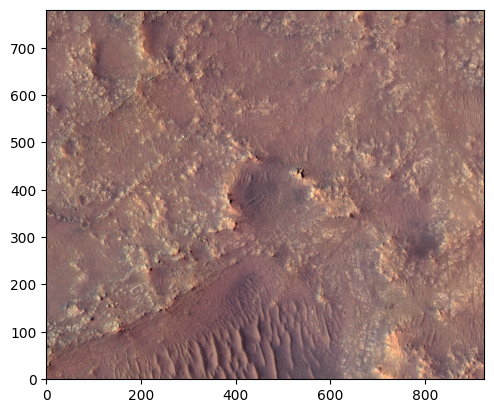

In [3]:
img = image.imread('data/jezero.png')
plt.imshow(img, origin='lower')

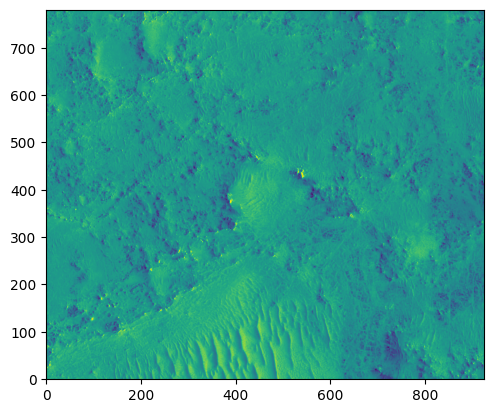

In [4]:
img_gray = rgb2gray(img)
plt.imshow(img_gray, origin='lower', cmap='viridis_r')

In [26]:
costmap = img_gray
m, n = costmap.shape
print(m, n)

781 926


Local planner on costmap

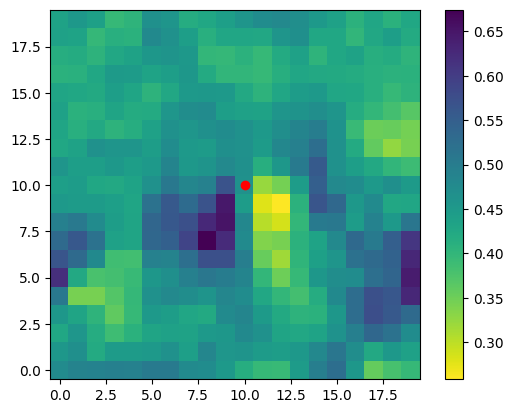

In [28]:
x = np.array([100, 100, 0])  # current (x, y, theta) pose
# Plot the costmap in radius 10 pixels around the current position
plt.imshow(costmap[max(0, x[0]-10):min(m, x[0]+10), max(0, x[1]-10):min(n, x[1]+10)], origin='lower', cmap='viridis_r')
# Show current position in the plot
plt.plot(x[0]-max(0, x[0]-10), x[1]-max(0, x[1]-10), 'ro')
# Show scale
plt.colorbar()

In [7]:
def closed_form_dubins_traj(x0, u, N, dt):
    def dx(v, w, t, eps=1e-15):
        return v * np.sin((w + eps) * t) / (w + eps)
    def dy(v, w, t, eps=1e-15):
        return v * (1 - np.cos((w + eps) * t)) / (w + eps)

    traj = np.zeros((N, 3))
    traj[:,0] = [x0[0] + dx(u[0], u[1], i * dt) for i in range(N)]
    traj[:,1] = [x0[1] + dy(u[0], u[1], i * dt) for i in range(N)]
    traj[:,2] = x0[2] + u[1] * np.arange(N) * dt

    return traj

In [8]:
def arc(speed, T, curvature):
    dt = 0.1
    t = np.arange(0, T, dt)
    x = np.zeros_like(t)
    y = np.zeros_like(t)
    theta = np.zeros_like(t)
    x[0] = 0
    y[0] = 0
    theta[0] = 0
    for i in range(1, len(t)):
        theta[i] = theta[i-1] + speed/curvature*dt
        x[i] = x[i-1] + speed*np.cos(theta[i])*dt
        y[i] = y[i-1] + speed*np.sin(theta[i])*dt
    return np.stack([x, y, theta]).T

In [12]:
# ENav - consider parameterized tree of trajectories
#  - constant curvature arcs
# 1) steering cost
# 2) costmap cost: sample at points along arc
# 3) global cost: djikstra's from endpoint to goal

T = 6.0  # s
dt = 0.1  # s
speed = 1.0  # m/s
omegas = np.linspace(-0.5, 0.5, 11)

arcs = [closed_form_dubins_traj(x, [speed, w], int(T/dt), dt) for w in omegas]

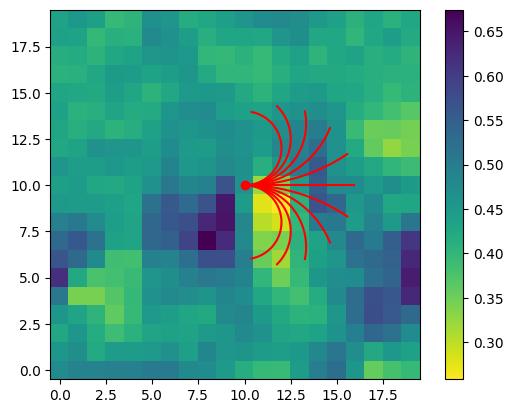

In [13]:
# Plot the costmap in radius 10 pixels around the current position
plt.imshow(costmap[max(0, x[0]-10):min(m, x[0]+10), max(0, x[1]-10):min(n, x[1]+10)], origin='lower', cmap='viridis_r')
# Show current position in the plot
plt.plot(x[0]-max(0, x[0]-10), x[1]-max(0, x[1]-10), 'ro')
# Plot arcs
for arc in arcs:
    plt.plot(arc[:,0]-max(0, x[0]-10), arc[:,1]-max(0, x[1]-10), 'r')
# Show scale
plt.colorbar()

In [31]:
def steering_cost(omega):
    return 1 - np.exp(-np.abs(omega))

def global_cost(x, x_goal):
    return np.linalg.norm(x - x_goal)

def costmap_cost(arc, costmap):
    # Sample costmap at points along arc
    # Return sum of costs
    return np.sum(costmap[arc[:,0].astype(int), arc[:,1].astype(int)])

In [32]:
def arc_cost(x, omega, x_goal, costmap):
    T = 6.0  # s
    dt = 0.1  # s
    speed = 1.0  # m/s
    arc = closed_form_dubins_traj(x, [speed, omega], int(T/dt), dt)
    s_cost = 1.0 * steering_cost(omega) 
    c_cost = 1.0 * costmap_cost(arc, costmap) 
    g_cost = 5.0 * global_cost(arc[-1,:], x_goal)
    return s_cost + c_cost + g_cost

x = np.array([100, 100, 0])
x_goal = np.array([200, 200, 0])

costs = [arc_cost(x, w, x_goal, costmap) for w in omegas]
costs

[749.8876860849539,
 747.8243936202912,
 745.2391053727101,
 742.1072617626446,
 738.476493846376,
 734.3902690715363,
 730.2976858605332,
 725.7948055522667,
 721.1281324431282,
 717.1432953465844,
 712.2211518367033,
 709.5607528024053,
 708.0446738634544,
 707.5867395020382,
 707.9603017610951,
 709.3205459024952,
 711.6418333390807,
 714.4480241681682,
 717.6908009749716,
 719.9183256584224]

In [33]:
goal_thresh = 10.0  # m
max_iters = 1000
omegas = np.linspace(-0.5, 0.5, 20)

x = np.array([100, 100, 0])
x_goal = np.array([500, 500, 0])

while np.linalg.norm(x[:2] - x_goal[:2]) > goal_thresh:
    # Compute costs for all arcs
    costs = [arc_cost(x, w, x_goal, costmap) for w in omegas]
    # Find minimum cost arc
    w_best = omegas[np.argmin(costs)]
    # Simulate arc
    arc = closed_form_dubins_traj(x, [speed, w_best], int(T/dt), dt)
    # Update state
    x = arc[-1,:]
    print(x)

[104.80516523 102.9027498    1.08684211]
[108.96405005 106.39638604   2.48421053]
[113.76921528 109.29913584   3.57105263]
[118.57438051 112.20188565   4.65789474]
[123.37954574 115.10463545   5.74473684]
[127.53843056 118.59827168   7.14210526]
[131.69731538 122.09190791   8.53947368]
[135.8562002  125.58554414   9.93684211]
[140.01508502 129.07918037  11.33421053]
[144.82025025 131.98193018  12.42105263]
[149.62541548 134.88467998  13.50789474]
[155.50173916 134.42757305  13.35263158]
[160.30690439 137.33032286  14.43947368]
[164.46578921 140.82395909  15.83684211]
[168.62467403 144.31759532  17.23421053]
[173.42983926 147.22034512  18.32105263]
[178.23500449 150.12309493  19.40789474]
[181.65713499 154.0497708   21.11578947]
[185.81601981 157.54340703  22.51315789]
[190.62118504 160.44615683  23.6       ]
[194.78006986 163.93979306  24.99736842]
[199.58523509 166.84254287  26.08421053]
[204.39040032 169.74529267  27.17105263]
[208.54928514 173.2389289   28.56842105]
[212.70816996 17

IndexError: index 781 is out of bounds for axis 0 with size 781

Compute optimal path from (0,0) to (781,926) as sequence of pixels through terrain map

Each pixel represents cost of traversing terrain at that location, with lower cost being better

In [ ]:
from astar import AStar

In [ ]:
class GlobalPlanner(AStar):

    def __init__(self, costmap):
        self.costmap = costmap
        self.width = costmap.shape[0]
        self.height = costmap.shape[1]

    def neighbors(self, node):
        x, y = node
        return [(nx, ny) for nx, ny in [(x+1, y), (x-1, y), (x, y+1), (x, y-1)] 
                if 0 <= nx < self.width and 0 <= ny < self.height]

    def distance_between(self, node1, node2):
        return self.costmap[node2]
    
    def heuristic_cost_estimate(self, node1, node2):
        """Straight line distance"""
        return np.linalg.norm(np.array(node1) - np.array(node2))

In [ ]:
gp_optimal = GlobalPlanner(costmap)

In [ ]:
optimal_path = list(gp_optimal.astar((0, 0), (m-1, n-1)))
dt = np.dtype('int32','int32')
optimal_path = np.array(optimal_path, dtype=dt)

In [ ]:
# Plot the path on the image
plt.rcParams["figure.figsize"] = [m/100, n/100]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots()
im = ax.imshow(img_gray, extent=[0, n-1, 0, m-1], origin='lower', cmap='viridis_r')

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
plt.colorbar(im, cax=cax)

ax.plot(optimal_path[:,1], optimal_path[:,0], ls='dotted', linewidth=2, color='black')
plt.show()

In [ ]:
# Compute cost of optimal path
cost = 0
for node in optimal_path:
    cost += costmap[node[0], node[1]]
print(f'Cost of optimal path: {cost}')

Add noise to map to obtain imperfect "global" information

In [ ]:
sigma = 0.1
map_noisy = costmap + np.random.normal(0, sigma, size=(m,n))

In [ ]:
# Plot true map and noisy map
fig, ax = plt.subplots(1, 2, figsize=(2*m/100, n/100))
im1 = ax[0].imshow(img_gray, extent=[0, n-1, 0, m-1], origin='lower', cmap='viridis_r')
im2 = ax[1].imshow(map_noisy, extent=[0, n-1, 0, m-1], origin='lower', cmap='viridis_r')

In [ ]:
gp = GlobalPlanner(map_noisy)

In [ ]:
path = list(gp.astar((0, 0), (m-1, n-1)))
dt = np.dtype('int32','int32')
path = np.array(path, dtype=dt)

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(img_gray, extent=[0, n-1, 0, m-1], origin='lower', cmap='viridis_r')

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
plt.colorbar(im, cax=cax)

ax.plot(optimal_path[:,1], optimal_path[:,0], ls='dotted', linewidth=2, color='black')
ax.plot(path[:,1], path[:,0], ls='dotted', linewidth=2, color='red')
plt.show()

Add obstacle to map